
# Micrograph Sources

This tutorial will demonstrate how to set up and use ASPIRE's
``MicrographSource`` classes.


In [ ]:
import os
import tempfile
import time
import numpy as np

from aspire.source import ArrayMicrographSource

C:\ProgramData\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


2024-07-13 12:57:28,989 INFO [numexpr.utils] Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-07-13 12:57:28,990 INFO [numexpr.utils] NumExpr defaulting to 8 threads.


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Overview
``MicrographSource`` is an abstract class which provides access to
three distinct subclasses.  The first two are
``ArrayMicrographSource`` and ``DiskMicrographSource`` which provide
access to array and disk backed micrograph data respectively.
``MicrographSimulation`` takes a volume and generates projection
images which are aggregated into synthetic microgaphs.  The following
illustrates an overview of the interfaces, and the tutorial will go
on to demonstrate common operations for each class.



.. mermaid::

  classDiagram
      class MicrographSource{
          micrograph_count: int
          micrograph_size: int
          dtype: np.dtype
          +asnumpy()
          +dtype
          +len()
          +repr()
          +images[]
          +micrograph_count
          +micrograph_size
          +save()
          +show()
       }

      class ArrayMicrographSource{
          micrographs: np.ndarray
       }

      class DiskMicrographSource{
          micrographs_path: str, Path, or list
       }

      class MicrographSimulation{
          volume: Volume
          micrograph_size: Optional, int
          micrograph_count: Optional, int
          particles_per_micrograph: Optional, int
          particle_amplitudes: Optional, np.ndarray
          projection_angles: Optional, np.ndarray
          seed: Optional, int
          ctf_filters: Optional, list
          noise_adder: Optional, NoiseAdder
          boundary: Optional, int
          interparticle_distance: Optional, int
          +boundary
          +centers
          +ctf_filters
          +clean_images[]
          +filter_indices
          +get_micrograph_index()
          +get_particle_index()
          +interparticle_distance
          +noise_adder
          +simulation
          +particle_amplitudes
          +particle_box_size
          +particle_per_micrograph
          +projection_angles
          +total_particle_count
          +volume
       }

       MicrographSource <|-- ArrayMicrographSource
       MicrographSource <|-- DiskMicrographSource
       MicrographSource <|-- MicrographSimulation
       MicrographSimulation o-- Volume
       MicrographSimulation *-- CTFFilter
       MicrographSimulation *-- NoiseAdder



## Creating an ArrayMicrographSource
An ``ArrayMicrographSource`` is populated with an array.  For this
demonstration, random data will initialize the object,
then this data will be saved off for use in the next example
(which loads data from files).



In [ ]:
# # Create an (2,512,512) array of data.
# # This represents two (512,512) micrographs.
# mgs_np = np.random.rand(2, 512, 512)

# # Construct the source
# src = ArrayMicrographSource(mgs_np)

# # Create a tmp dir for saving the data to.
# # This just for ensuring the tutorial script is portable,
# tmp_dir = tempfile.TemporaryDirectory()

# # Save the data as multiple MRC files
# # This method returns a file_list,
# # which might be useful for loading or other operations.
# file_list = src.save(tmp_dir.name)

## Creating a DiskMicrographSource
A ``DiskMicrographSource`` is populated with str or list
representing the location of MRC files.



In [ ]:
# from aspire.source import DiskMicrographSource

# # Load files in directory
# src = DiskMicrographSource(tmp_dir.name)

# # Load files from a list
# src = DiskMicrographSource(file_list)

## Creating a Micrograph Simulation
A ``MicrographSimulation`` is populated with particle projections
from a ``Volume``, so we'll begin by generating a ``Volume``.



In [ ]:
from aspire.source import MicrographSimulation
from aspire.volume import Volume
import numpy as np
import pandas as pd
import starfile
# from aspire.volume import AsymmetricVolume

# # Generate one (100,100,100) ``Volume``.
# vol = AsymmetricVolume(
#     L=100,
#     C=1,
#     seed=1234,
#     dtype=np.float32,
# ).generate()

# file_path = os.path.join(
#     os.path.dirname(os.getcwd()), "aspire/data", "5lzf-pdb-bundle1.mrc"
# )
vol = Volume.load('J3_004_volume_map.mrc', dtype=np.float64)

2024-07-13 12:57:32,264 INFO [aspire.volume.volume] J3_004_volume_map.mrc with dtype float32 loaded as <class 'numpy.float64'>


In [ ]:
refine_result_path = 'particles.star'
refine_result = starfile.read(refine_result_path)
refine_result = refine_result['particles']
refine_result

,rlnImageName,rlnAngleRot,rlnAngleTilt,rlnAnglePsi,rlnOriginXAngst,rlnOriginYAngst,rlnDefocusU,rlnDefocusV,rlnDefocusAngle,rlnPhaseShift,rlnCtfBfactor,rlnOpticsGroup,rlnRandomSubset,rlnClassNumber
0,000001@J1/imported/009450134240439197669_Falco...,27.232986,101.924133,118.272339,2.804344,-0.071906,16114.192383,15825.589844,2.787752,0.0,0.0,2,1,1
1,000002@J1/imported/009450134240439197669_Falco...,135.509964,80.956985,63.972885,-0.359531,6.112031,16201.632812,15913.030273,2.787752,0.0,0.0,2,2,1
2,000003@J1/imported/009450134240439197669_Falco...,142.685806,71.912315,127.747437,6.974906,1.653844,15950.035156,15661.432617,2.787752,0.0,0.0,2,1,1
3,000004@J1/imported/009450134240439197669_Falco...,132.415039,100.085007,61.299046,-1.078594,0.647156,16118.767578,15830.165039,2.787752,0.0,0.0,2,2,1
4,000005@J1/imported/009450134240439197669_Falco...,-154.759628,108.400917,-88.782585,2.229094,4.386281,15892.583984,15603.981445,2.787752,0.0,0.0,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49386,000668@J1/imported/002543179792178278827_Falco...,-32.930584,162.047668,-111.021210,-34.165249,-25.660749,23859.585938,23600.019531,-67.061165,0.0,0.0,2,1,1
49387,000670@J1/imported/002543179792178278827_Falco...,160.914749,158.862503,-41.369183,-8.125406,-4.817719,23550.390625,23290.824219,-67.061165,0.0,0.0,2,2,1
49388,000673@J1/imported/002543179792178278827_Falco...,85.890823,150.898941,-7.460076,-18.479906,-7.981594,24017.113281,23757.546875,-67.061165,0.0,0.0,2,1,1
49389,000678@J1/imported/002543179792178278827_Falco...,131.126938,165.740753,7.338231,-31.998281,-38.901279,24291.025391,24031.458984,-67.061165,0.0,0.0,2,2,1


In [ ]:
n_micrographs = 84
random_defocus_values = refine_result.rlnDefocusV.sample(n_micrographs, random_state=42)

In [ ]:
random_defocus_values

39497    27063.888672
26366    19748.894531
36154    24486.117188
11165    28391.523438
48059    30975.164062
             ...     
1738     27914.580078
11444   -65196.367188
508      16059.564453
28624    23914.521484
24129    33447.753906
Name: rlnDefocusV, Length: 84, dtype: float64

In [ ]:
n_particles_per_micrograph = 150
seed = 42

## CTF Filters
By default, no CTF corruption is configured. To apply CTF filters,
we have to pass them as arguments to the ``MicrographSimulation``.
It is possible to apply a single CTF, different CTF per-micrograph
or different CTF per-particle by configuring a list of matching size.



In [ ]:
from aspire.operators import RadialCTFFilter

# Create our CTF Filter and add it to a list.
# This configuration will apply the same CTF to all particles.
# ctfs = [
#     RadialCTFFilter(pixel_size=1.16, voltage=300, defocus=16500, Cs=2.7, alpha=0.03, B=0),
# ]


#defocus_min = 0.7e4              # Minimum defocus value (in angstroms).
#defocus_max = 2.6e4              # Maximum defocus value (in angstroms).
#defocus_ct = n_micrographs
#random_defocus_values = np.random.uniform(defocus_min, defocus_max, defocus_ct)
# Create filters
ctfs = [RadialCTFFilter(pixel_size=1.77, voltage=300, defocus=d, Cs=2.7, alpha=0.1)
        for d in random_defocus_values]

src = MicrographSimulation(
    vol,
    particles_per_micrograph=n_particles_per_micrograph,
    micrograph_size=4096,
    micrograph_count=n_micrographs,
    particle_amplitudes=1,
    ctf_filters=ctfs,
    seed=seed,
)

# Plot the micrographs
#src.images[:].show()

2024-07-13 12:59:42,675 INFO [aspire.source.image] Creating Simulation with 12600 images.


In [ ]:
src.save('sim_images/', name_prefix='sim_image')

2024-07-13 13:26:56,757 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-07-13 13:26:56,784 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-07-13 13:26:56,810 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-07-13 13:26:56,834 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-07-13 13:26:56,860 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-07-13 13:26:56,885 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-07-13 13:26:56,911 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-07-13 13:26:56,935 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-07-13 13:26:56,959 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-07-13 13:26:56,983 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-07-13 13:26:57,008 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-07-13 13:26:57,032 INFO [aspire.storage.starfile]

[('sim_images/sim_image_0.mrc', 'sim_images/sim_image_0.star'),
 ('sim_images/sim_image_1.mrc', 'sim_images/sim_image_1.star'),
 ('sim_images/sim_image_2.mrc', 'sim_images/sim_image_2.star'),
 ('sim_images/sim_image_3.mrc', 'sim_images/sim_image_3.star'),
 ('sim_images/sim_image_4.mrc', 'sim_images/sim_image_4.star'),
 ('sim_images/sim_image_5.mrc', 'sim_images/sim_image_5.star'),
 ('sim_images/sim_image_6.mrc', 'sim_images/sim_image_6.star'),
 ('sim_images/sim_image_7.mrc', 'sim_images/sim_image_7.star'),
 ('sim_images/sim_image_8.mrc', 'sim_images/sim_image_8.star'),
 ('sim_images/sim_image_9.mrc', 'sim_images/sim_image_9.star'),
 ('sim_images/sim_image_10.mrc', 'sim_images/sim_image_10.star'),
 ('sim_images/sim_image_11.mrc', 'sim_images/sim_image_11.star'),
 ('sim_images/sim_image_12.mrc', 'sim_images/sim_image_12.star'),
 ('sim_images/sim_image_13.mrc', 'sim_images/sim_image_13.star'),
 ('sim_images/sim_image_14.mrc', 'sim_images/sim_image_14.star'),
 ('sim_images/sim_image_15.mrc

In [ ]:
vol = Volume.load('J3_004_volume_mask_refine.mrc', dtype=np.float64)

2024-07-13 14:33:15,318 INFO [aspire.volume.volume] J3_004_volume_mask_refine.mrc with dtype float32 loaded as <class 'numpy.float64'>


In [ ]:
from aspire.operators import RadialCTFFilter

# Create our CTF Filter and add it to a list.
# This configuration will apply the same CTF to all particles.
# ctfs = [
#     RadialCTFFilter(pixel_size=1.16, voltage=300, defocus=16500, Cs=2.7, alpha=0.03, B=0),
# ]


#defocus_min = 0.7e4              # Minimum defocus value (in angstroms).
#defocus_max = 2.6e4              # Maximum defocus value (in angstroms).
#defocus_ct = n_micrographs
#random_defocus_values = np.random.uniform(defocus_min, defocus_max, defocus_ct)
# Create filters
# ctfs = [RadialCTFFilter(pixel_size=1.77, voltage=300, defocus=d, Cs=2.7, alpha=0.1)
#         for d in random_defocus_values]

src = MicrographSimulation(
    vol,
    particles_per_micrograph=n_particles_per_micrograph,
    micrograph_size=4096,
    micrograph_count=n_micrographs,
    particle_amplitudes=1,
#     ctf_filters=ctfs,
    seed=seed,
)

# Plot the micrographs
#src.images[:].show()

2024-07-13 14:39:35,569 INFO [aspire.source.image] Creating Simulation with 12600 images.


In [ ]:
src.save('sim_images2/', name_prefix='sim_image')

2024-07-13 15:06:42,154 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-07-13 15:06:42,209 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-07-13 15:06:42,238 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-07-13 15:06:42,265 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-07-13 15:06:42,293 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-07-13 15:06:42,320 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-07-13 15:06:42,349 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-07-13 15:06:42,377 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-07-13 15:06:42,416 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-07-13 15:06:42,448 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-07-13 15:06:42,477 INFO [aspire.storage.starfile] Created StarFile with blocks: 
2024-07-13 15:06:42,520 INFO [aspire.storage.starfile]

[('sim_images2/sim_image_0.mrc', 'sim_images2/sim_image_0.star'),
 ('sim_images2/sim_image_1.mrc', 'sim_images2/sim_image_1.star'),
 ('sim_images2/sim_image_2.mrc', 'sim_images2/sim_image_2.star'),
 ('sim_images2/sim_image_3.mrc', 'sim_images2/sim_image_3.star'),
 ('sim_images2/sim_image_4.mrc', 'sim_images2/sim_image_4.star'),
 ('sim_images2/sim_image_5.mrc', 'sim_images2/sim_image_5.star'),
 ('sim_images2/sim_image_6.mrc', 'sim_images2/sim_image_6.star'),
 ('sim_images2/sim_image_7.mrc', 'sim_images2/sim_image_7.star'),
 ('sim_images2/sim_image_8.mrc', 'sim_images2/sim_image_8.star'),
 ('sim_images2/sim_image_9.mrc', 'sim_images2/sim_image_9.star'),
 ('sim_images2/sim_image_10.mrc', 'sim_images2/sim_image_10.star'),
 ('sim_images2/sim_image_11.mrc', 'sim_images2/sim_image_11.star'),
 ('sim_images2/sim_image_12.mrc', 'sim_images2/sim_image_12.star'),
 ('sim_images2/sim_image_13.mrc', 'sim_images2/sim_image_13.star'),
 ('sim_images2/sim_image_14.mrc', 'sim_images2/sim_image_14.star'),


In [ ]:
import mrcfile
with mrcfile.open('sim_images2/sim_image_83.mrc') as mrc:
    image = mrc.data.astype(np.float32)

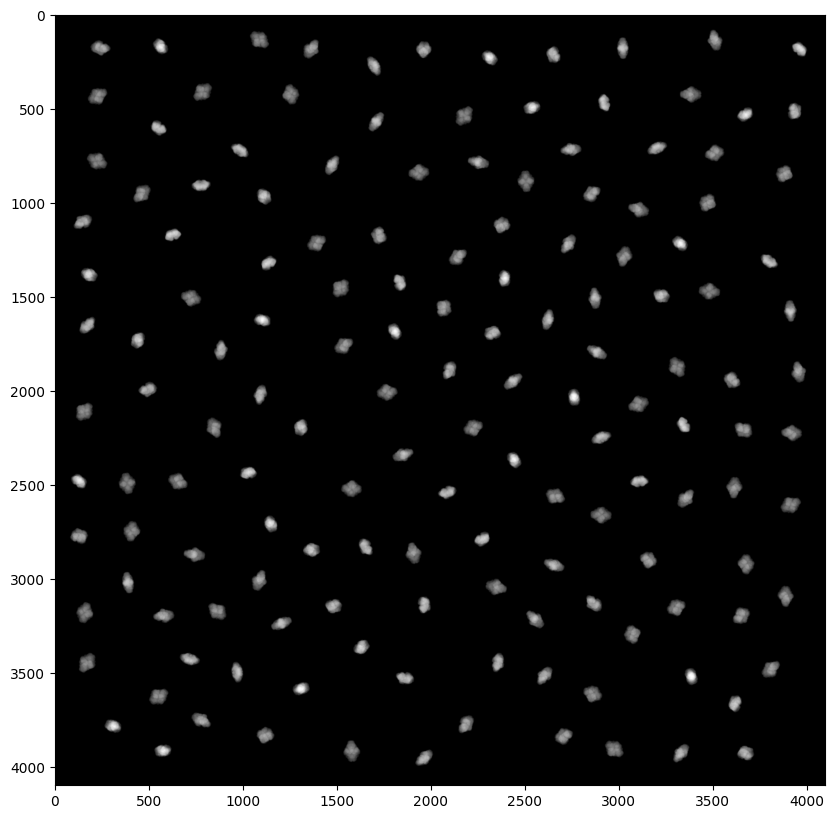

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image.squeeze(), cmap="gray")

## Noise
By default, no noise corruption is configured.
To apply noise, pass a ``NoiseAdder`` to ``MicrographSimulation``.



In [ ]:
import mrcfile
with mrcfile.open('sim_images/sim_image_83.mrc') as mrc:
    image = mrc.data.astype(np.float32)

In [ ]:
import matplotlib.pyplot as plt

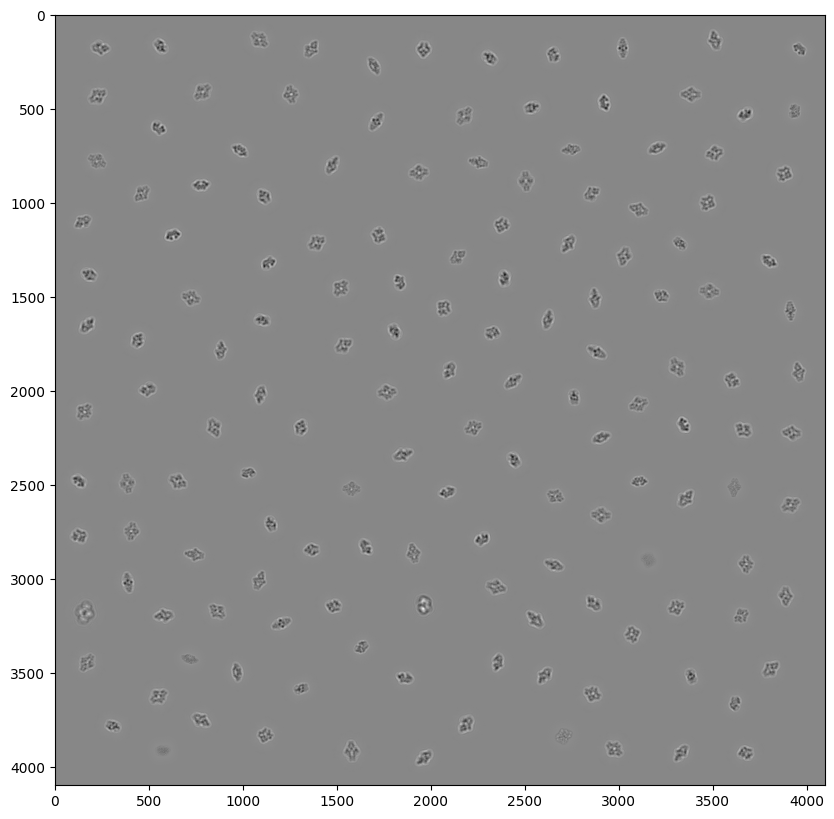

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image.squeeze(), cmap="gray")

In [ ]:
import numpy as np
from numpy.typing import NDArray
from tqdm.auto import tqdm
from pathlib import Path


def add_noise(image: NDArray[np.float32], snr: float = 0.1) -> NDArray[np.float32]:
    """
    Add noise to the input image.

    Args:
        image (NDArray[np.float32]): Input image.
        snr (float): Signal-to-noise ratio.

    Returns:
        NDArray[np.float32]: Noisy image.
    """
    sample_var = image.var()
    target_noise_var = sample_var / snr
    print(
        f"Sample Variance: {sample_var:.7f}. Target Noise Variance: {target_noise_var:.7f}")
    noise = np.random.normal(0, np.sqrt(target_noise_var), size=image.shape)
    return (image + noise).astype(np.float32)

In [ ]:
noise_image_dir = Path("noisy_sim")
for path in tqdm(list(Path('sim_images').glob("**/*.mrc"))):
        with mrcfile.open(path) as mrc:
            image = mrc.data.astype(np.float32)
        noise_image = add_noise(image, 0.005)
        plt.figure(figsize=(10, 10))
        plt.imshow(noise_image.squeeze(), cmap='gray')
        plt.show()
        noise_image_path = noise_image_dir.joinpath(
            path.parent.stem, f"{path.stem}.npy")
        np.save(noise_image_path, noise_image.squeeze())

In [ ]:
from PIL import Image
from skimage import morphology
from skimage.filters import threshold_li


def threshold(image: NDArray[np.float32]) -> NDArray[np.uint8]:
    """
    Threshold the input image.

    Args:
        image (NDArray[np.float32]): Input image.

    Returns:
        NDArray[np.uint8]: Thresholded image.
    """
    image_threshold = 0.015
    # image_threshold: np.float32 = threshold_li(image)
    return (image > image_threshold).astype(np.uint8) * 255


def processing(image: NDArray[np.float32]) -> NDArray[np.uint8]:
    """
    Apply processing steps to the input image.

    Args:
        image (NDArray[np.float32]): Input image.

    Returns:
        NDArray[np.uint8]: Processed image.
    """
    image = morphology.black_tophat(image, morphology.disk(20))
    image = morphology.remove_small_objects(
        image > 0, min_size=128, connectivity=1)
    image = morphology.closing(image, morphology.disk(20))
    return image.astype(np.uint8) * 255


def processing2(image: NDArray[np.float32]) -> NDArray[np.uint8]:
    """
    Apply processing steps to the input image.

    Args:
        image (NDArray[np.float32]): Input image.

    Returns:
        NDArray[np.uint8]: Processed image.
    """
    return image

def numpy_to_PIL(image: NDArray) -> Image:
    """
    Convert numpy array to PIL Image.

    Args:
        image (NDArray): Input image.

    Returns:
        Image: PIL Image.
    """
    return Image.fromarray(image).convert('L')


def self2binary(image: NDArray[np.float_]) -> NDArray[np.uint8]:
    """
    Convert image to binary.

    Args:
        image (NDArray[np.float64]): Input image.

    Returns:
        NDArray[np.uint8]: Binary image.
    """
    clean_image = threshold(image)
    clean_image = processing(clean_image)
    return clean_image

def self2binary2(image: NDArray[np.float_]) -> NDArray[np.uint8]:
    """
    Convert image to binary.

    Args:
        image (NDArray[np.float64]): Input image.

    Returns:
        NDArray[np.uint8]: Binary image.
    """
    clean_image = threshold(image)
    clean_image = processing2(clean_image)
    return clean_image

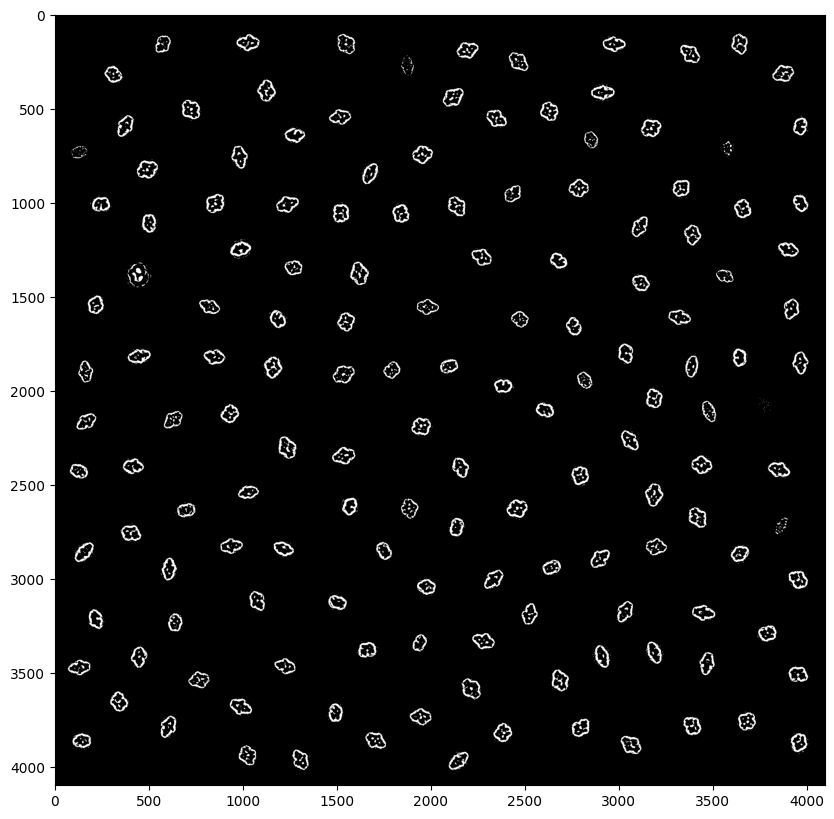

In [ ]:
with mrcfile.open('sim_images/sim_image_0.mrc') as mrc:
    image = mrc.data.astype(np.float32)
clean_image = threshold(image[0])
plt.figure(figsize=(10, 10))
plt.imshow(clean_image.squeeze(), cmap="gray")

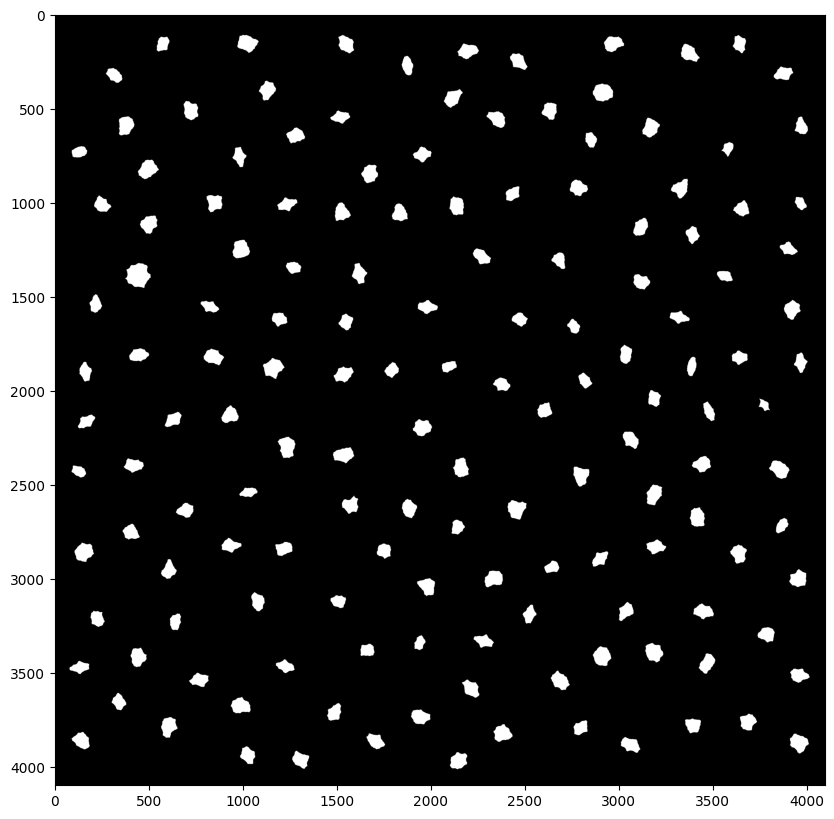

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(processing(clean_image.squeeze()), cmap="gray")

In [ ]:
import gc

clean_image_dir = Path('ground_sim')
for path in tqdm(list(Path('sim_images2').glob("**/*.mrc"))):
        with mrcfile.open(path) as mrc:
            image = mrc.data.astype(np.float32)
        clean_image = self2binary2(image[0])
        clean_image_path = clean_image_dir.joinpath(f"{path.stem}.png")
        numpy_to_PIL(clean_image).save(clean_image_path)
        plt.imshow(numpy_to_PIL(clean_image), cmap="gray")
        plt.show()
        gc.collect()